Benjamin Nguyen

Computer Vision

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage 
from skimage import io, color, filters, util, data, transform, feature
from skimage.registration import optical_flow_ilk


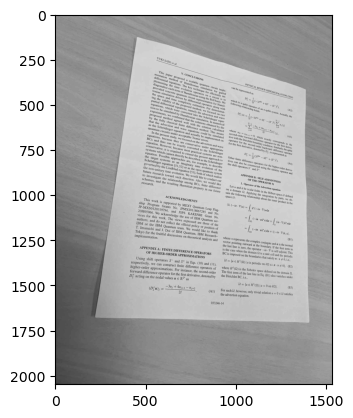

In [ ]:
# Load and preprocess image
img_color = io.imread('input.jpg')
img_gray = util.img_as_float32(color.rgb2gray(img_color))
img_gray = transform.rescale(img_gray, 1/5, channel_axis=None)
plt.imshow(img_gray, cmap='gray')

img_gray 

# Bonus Problem 1

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, morphology, feature, measure, transform, util
from scipy import ndimage as ndi

# ---------- Tunables (good starting points for an image scaled by 1/5) ----------
MORPH = 7                 # dilation kernel (odd integer)
σ_blur = 1.0              # Gaussian blur on grayscale (in px of the scaled image)
σ_canny = 1.2             # extra smoothing inside Canny
τ_low, τ_high = 0.06, 0.18  # Canny hysteresis thresholds (fraction in [0,1])
hough_threshold = 10
line_length = 25
line_gap = 3

# Filter large contours only (relative to image size)
H, W = img_gray.shape
min_perimeter = 0.05*(H+W)     # ~5% of image perimeter
min_area     = 0.05*H*W        # ~5% of image area
poly_tol     = 3.0             # polygon simplification tolerance (in pixels)

# ---------- Helpers ----------
def polygon_area_rc(rc):
    """Shoelace area; rc is (N,2) in (row, col)."""
    xy = np.fliplr(rc)  # (r,c) -> (x,y)
    x, y = xy[:,0], xy[:,1]
    return 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

def poly_perimeter_rc(rc):
    d = np.diff(rc, axis=0, append=rc[:1])
    return np.sum(np.hypot(d[:,0], d[:,1]))

# ---------- 1) Preprocess ----------
# Gentle denoise (keeps edges crisp after downscale)
blurred = filters.gaussian(img_gray, sigma=σ_blur, preserve_range=True)

# “white-on-white” boost: binarize and dilate bright structures
th = filters.threshold_otsu(blurred)
bin_img = blurred > th
dilated = morphology.dilation(bin_img, morphology.square(MORPH))

# ---------- 2) Edges + Lines ----------
edges = feature.canny(util.img_as_float(dilated.astype(float)),
                      sigma=σ_canny, low_threshold=τ_low, high_threshold=τ_high)

lines = transform.probabilistic_hough_line(
    edges,
    threshold=hough_threshold,
    line_length=line_length,
    line_gap=line_gap
)

# ---------- 3) Contours -> polygons ----------
filled = ndi.binary_fill_holes(edges)
contours = measure.find_contours(filled.astype(float), level=0.5)

polys = []
for c in contours:
    if poly_perimeter_rc(c) > min_perimeter and polygon_area_rc(c) > min_area:
        approx = measure.approximate_polygon(c, tolerance=poly_tol)
        if not np.allclose(approx[0], approx[-1]):
            approx = np.vstack([approx, approx[0]])
        polys.append(approx)

# ---------- 4) Visualize ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0,0].imshow(img_gray, cmap='gray')
axs[0,0].set_title("Gray (scaled)")
axs[0,0].axis('off')

axs[0,1].imshow(dilated, cmap='gray')
axs[0,1].set_title("Dilated mask")
axs[0,1].axis('off')

axs[1,0].imshow(edges, cmap='gray')
axs[1,0].set_title("Canny edges")
axs[1,0].axis('off')

axs[1,1].imshow(img_color)
for (x0, y0), (x1, y1) in lines:
    axs[1,1].plot([x0*5, x1*5], [y0*5, y1*5], linewidth=1)  # rescale to original if you want
for p in polys:
    axs[1,1].plot(p[:,1]*5, p[:,0]*5, linewidth=2)          # rescale polygon to original
axs[1,1].set_title("Polygons + Hough lines (over original)")
axs[1,1].axis('off')

plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 2)

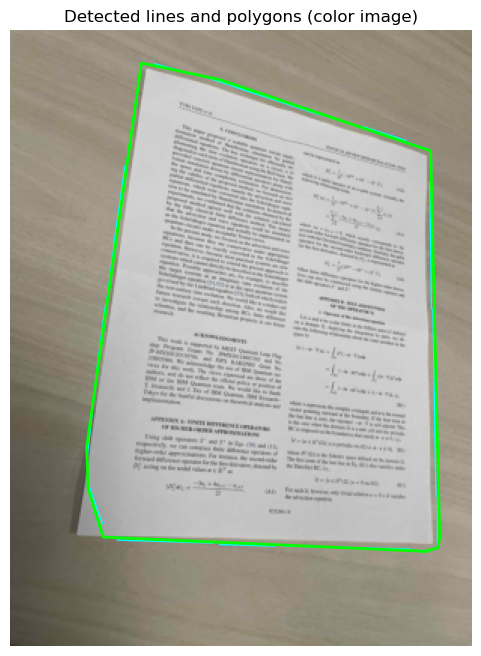

In [31]:
#!/usr/bin/env python3
# pip install scikit-image scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, feature, measure, transform, util, color
from scipy import ndimage as ndi

# ---------------------------------------------------------
# Load your color image
# ---------------------------------------------------------
img_color = io.imread('input.jpg')

# Downscale if it’s large (optional)
img_color = transform.rescale(img_color, 1/5, channel_axis=-1)

# ---------------------------------------------------------
# 1. Preprocess: blur & dilation (operate on lightness channel)
# ---------------------------------------------------------
gray_like = color.rgb2gray(img_color)               # use intensity for edges
blurred   = filters.gaussian(gray_like, sigma=1.0)  # denoise
th        = filters.threshold_otsu(blurred)
mask      = blurred > th
dilated   = morphology.dilation(mask, morphology.square(7))

# ---------------------------------------------------------
# 2. Edge and line detection
# ---------------------------------------------------------
edges = feature.canny(dilated, sigma=1.2,
                      low_threshold=0.06, high_threshold=0.18)

lines = transform.probabilistic_hough_line(
    edges, threshold=10, line_length=25, line_gap=3
)

# ---------------------------------------------------------
# 3. Contours → polygons
# ---------------------------------------------------------
filled = ndi.binary_fill_holes(edges)
contours = measure.find_contours(filled.astype(float), level=0.5)

H, W = gray_like.shape
min_perimeter = 0.05 * (H + W)
min_area      = 0.05 * H * W
poly_tol      = 3.0

def poly_area(rc):
    xy = np.fliplr(rc)
    x, y = xy[:,0], xy[:,1]
    return 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

def poly_perimeter(rc):
    d = np.diff(rc, axis=0, append=rc[:1])
    return np.sum(np.hypot(d[:,0], d[:,1]))

polys = []
for c in contours:
    if poly_perimeter(c) > min_perimeter and poly_area(c) > min_area:
        approx = measure.approximate_polygon(c, tolerance=poly_tol)
        if not np.allclose(approx[0], approx[-1]):
            approx = np.vstack([approx, approx[0]])
        polys.append(approx)

# ---------------------------------------------------------
# 4. Draw on color image
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_color)

# Draw Hough lines
for (p0, p1) in lines:
    (x0, y0), (x1, y1) = p0, p1
    ax.plot([x0, x1], [y0, y1], color='cyan', linewidth=1)

# Draw polygons
for poly in polys:
    ax.plot(poly[:,1], poly[:,0], color='lime', linewidth=2)

ax.set_title("Detected lines and polygons (color image)")
ax.axis('off')
plt.show()


[[1711.5 1404. ]
 [1678.   221.5]
 [ 124.5  450. ]
 [ 416.  1388.5]
 [1711.5 1404. ]]


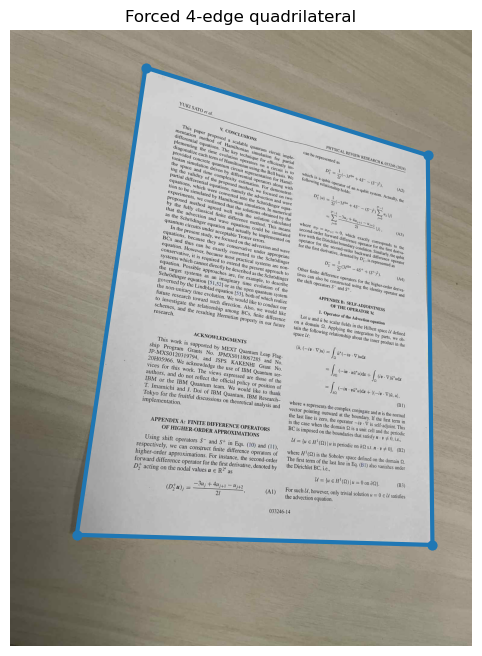

In [78]:
# pip install scikit-image scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, feature, measure, transform, util
from scipy import ndimage as ndi

# ------------------------
# Load color image
# ------------------------
img_color = io.imread('input.jpg')              # your image
# Optional: downscale if huge
# img_color = transform.rescale(img_color, 1/3, channel_axis=-1, anti_aliasing=True)

H, W = img_color.shape[:2]

# ------------------------
# Preprocess (use intensity only for edges)
# ------------------------
I = color.rgb2gray(img_color)
I_blur = filters.gaussian(I, sigma=1.0)
th = filters.threshold_otsu(I_blur)
mask = I_blur > th
mask = morphology.dilation(mask, morphology.square(7))

edges = feature.canny(I_blur, sigma=1.2, low_threshold=0.06, high_threshold=0.18)

# Fill and keep the largest region
filled = ndi.binary_fill_holes(edges | mask)
lab, nlab = ndi.label(filled)
if nlab == 0:
    raise RuntimeError("No regions found—check thresholds or lighting.")

sizes = ndi.sum(filled, lab, index=np.arange(1, nlab+1))
label_max = (np.argmax(sizes) + 1)
big = (lab == label_max)

# Get contour of the largest region (pick the longest one if multiple)
contours = measure.find_contours(big.astype(float), level=0.5)
contours.sort(key=lambda c: len(c), reverse=True)
cont = contours[0]  # (N, 2) in (row, col)

# ------------------------
# Force 4 vertices with a tolerance search
# ------------------------
def approx_vertices(rc, tol):
    poly = measure.approximate_polygon(rc, tolerance=tol)
    # ensure closed polygon
    if not np.allclose(poly[0], poly[-1]):
        poly = np.vstack([poly, poly[0]])
    return poly

def force_n_vertices(rc, n=4, tol_lo=0.5, tol_hi=50.0, max_iter=30):
    """
    Binary search a tolerance for Douglas–Peucker to produce exactly n vertices.
    rc: (N,2) array in (row, col). Returns (n+1,2) closed polygon or None.
    """
    best = None
    for _ in range(max_iter):
        mid = 0.5 * (tol_lo + tol_hi)
        poly = approx_vertices(rc, mid)
        # closed polygon has len = n+1
        k = len(poly) - 1
        if k == n:
            best = poly
            # try a tad larger to keep it stable but still 4
            tol_lo = mid
        elif k > n:
            # too many points -> increase tolerance
            tol_lo = mid
        else:
            # too few points -> decrease tolerance
            tol_hi = mid
    return best

quad = force_n_vertices(cont, n=4)
# Fallback: try convex hull if needed
if quad is None:
    from skimage.morphology import convex_hull_image
    hull = convex_hull_image(big)
    hull_contours = measure.find_contours(hull.astype(float), level=0.5)
    hull_contours.sort(key=lambda c: len(c), reverse=True)
    quad = force_n_vertices(hull_contours[0], n=4)
print(quad)
# if quad is None:
#     print(quad)
#     raise RuntimeError("Could not force exactly 4 vertices. Try adjusting thresholds.")

# ------------------------
# Visualize (draw the 4 edges)
# ------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_color)
# quad is (5,2): r,c with last point == first
ax.plot(quad[:,1], quad[:,0], linewidth=3)  # (col=x, row=y)
ax.scatter(quad[:-1,1], quad[:-1,0], s=40)  # corner markers
ax.set_title("Forced 4-edge quadrilateral")
ax.axis('off')
plt.show()


Detected corners: 7
[[1535.  1017.5]
 [1006.    52.5]
 [ 237.5  656. ]
 [ 485.5  897. ]
 [ 308.5 1319. ]
 [1032.  2021.5]
 [1535.  1399.5]]


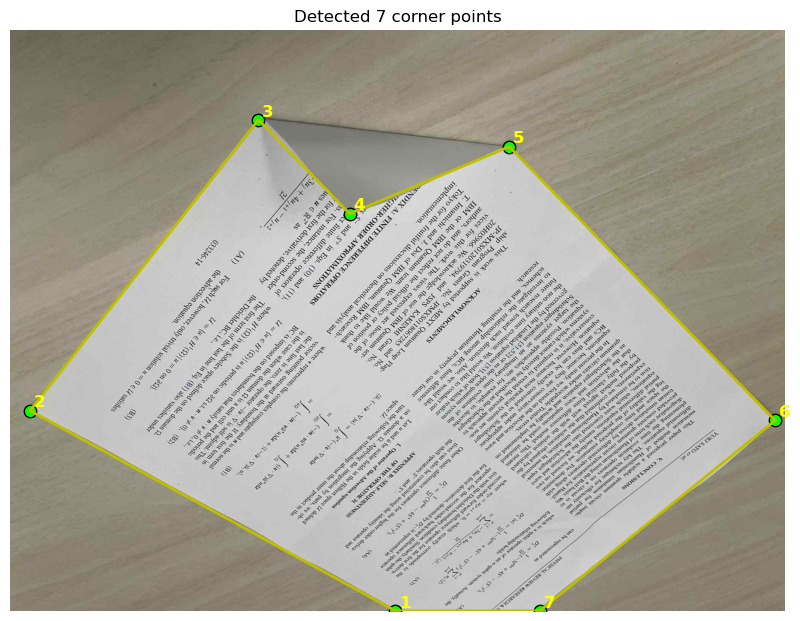

In [77]:
# pip install scikit-image scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, feature, measure, transform, util
from scipy import ndimage as ndi

# ------------------------
# Load color image
# ------------------------
img_color = io.imread('input1.jpg')              # your image
# Optional: downscale if huge
# img_color = transform.rescale(img_color, 1/3, channel_axis=-1, anti_aliasing=True)

H, W = img_color.shape[:2]

# ------------------------
# Preprocess (use intensity only for edges)
# ------------------------
I = color.rgb2gray(img_color)
I_blur = filters.gaussian(I, sigma=1.0)
th = filters.threshold_otsu(I_blur)
mask = I_blur > th
mask = morphology.dilation(mask, morphology.square(7))

edges = feature.canny(I_blur, sigma=1.2, low_threshold=0.06, high_threshold=0.18)

# Fill and keep the largest region
filled = ndi.binary_fill_holes(edges | mask)
lab, nlab = ndi.label(filled)
if nlab == 0:
    raise RuntimeError("No regions found—check thresholds or lighting.")

sizes = ndi.sum(filled, lab, index=np.arange(1, nlab+1))
label_max = (np.argmax(sizes) + 1)
big = (lab == label_max)

# ------------------------
# Find contour of the largest region
# ------------------------
contours = measure.find_contours(big.astype(float), level=0.5)
contours.sort(key=lambda c: len(c), reverse=True)
cont = contours[0]  # (N, 2) in (row, col)

# ------------------------
# Approximate polygon (variable number of corners)
# ------------------------
def approx_vertices(rc, tol):
    poly = measure.approximate_polygon(rc, tolerance=tol)
    # ensure closed polygon
    if not np.allclose(poly[0], poly[-1]):
        poly = np.vstack([poly, poly[0]])
    return poly

# Use fixed tolerance (not forced to 4)
tolerance = 100.0   # adjust this if you get too many or too few corners
poly = approx_vertices(cont, tolerance)
num_corners = len(poly) - 1  # subtract duplicate closing point

print(f"Detected corners: {num_corners}")
print(poly[:-1])  # print corner coordinates

# ------------------------
# Visualize (draw all corners)
# ------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_color)

# Draw polygon outline (optional)
ax.plot(poly[:,1], poly[:,0], 'y-', linewidth=2)

# Draw corner points
corners = poly[:-1]
ax.scatter(corners[:,1], corners[:,0], s=80, c='lime', marker='o', edgecolor='black')

# Label each corner with its index
for i, (r, c) in enumerate(corners):
    ax.text(c + 10, r - 10, f'{i+1}', color='yellow', fontsize=12, weight='bold')

ax.set_title(f"Detected {num_corners} corner points")
ax.axis('off')
plt.show()

